# 导入相关的package

In [1]:
# 基础的package
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 模型相关的package
from xgboost import XGBClassifier, plot_importance, XGBRegressor
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from gplearn.genetic import SymbolicTransformer

### 画图全局设置

In [2]:
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.axisbelow'] = True
colors = ['#44A948', '#137CB1', '#EACC80', '#A8D7E2', '#E58061']

# 数据相关的函数

### 计算收益率的文件，希望是一个字典，然后每个品种对应一个DataFrame,纵轴是时间，横轴是收益率，收益率为一分钟，五分钟和十分钟，二十分钟以及一个小时。

### 计算因子，然后滞后一分钟，因为害怕出现未来函数

### 刚开始最主要的是判断出，那天是期权的行权日, 然后进行分段的处理

### 如果可以的话，希望可以预测三个模型，因为希望可以对极端行情有更好的适应性

### 读取数据并去除重复行

### 读取期权快照数据

In [3]:
# 读取未经过处理的数据，需要判断行权日以及空缺值，还需要观察形态
def get_snapshot():
    snapshot = pd.read_csv('./csv/market.csv',index_col = None, header = None)
    snapshot.columns = ['kind','datetime','open','high','low','close','vol']
    snapshot.drop_duplicates(inplace=True)
    snapshot.reset_index(drop=True,inplace=True)
    return snapshot

### 读取逐笔成交数据

In [4]:
def get_tick():
    tick = pd.read_csv('./csv/depth.csv',index_col = None, header = None)
    tick.columns = ['amount', 'price', 'datetime', 'type', 'kind']
    tick.drop_duplicates(inplace=True)
    tick.reset_index(drop=True,inplace=True)
    return tick

### 读取现货数据

In [5]:
def get_spot():
    spot = pd.read_csv('./csv/spot.csv',index_col = None,header = None)
    spot.columns = ['datetime', 'kind', 'open', 'high', 'low', 'close', 'vol']
    spot.drop_duplicates(inplace=True)
    spot.reset_index(drop=True,inplace=True)
    return spot

### 期权 填充时间轴

In [6]:
def get_digit_opt_continue(digit_name, snapshot):
    y = snapshot[snapshot['kind'] == digit_name]
    y = y.groupby('datetime').tail(1).set_index('datetime')

    timeline = pd.date_range(y.index[0], y.index[-1], freq = '1min')
    timeline = list(map(str, timeline))

    _timeline = []
    for i in timeline:
        if i not in y.index:
            _timeline.append(i)

    _y = pd.DataFrame(
        [[digit_name,np.nan,np.nan,np.nan,np.nan,np.nan]]*len(_timeline),
        index = _timeline,
        columns=y.columns,
    )

    y = pd.concat([_y,y]).sort_index()
    return y

### 获得某一个种类的现货数据

In [7]:
def get_digit(name,spot):
    return  spot[spot.kind == name]

### 判断行权日（不精确）

In [8]:
def get_strike_day(opt):
    st = opt.apply(lambda x:(np.isnan(x.close)) and (x.name[-8:-6]=='16'),axis = 1)
    st = st[st]
    st.index = st.index.map(lambda x:x[:10])
    st = st.groupby(st.index).sum()

    ans = st[st == 60].index.tolist()
    return ans

In [9]:
%%time
snapshot = get_snapshot()
tick = get_tick()
spot = get_spot()

Wall time: 4min 55s


In [10]:
# 暂时主要是快照的数据来构造特征，所以先对快照数据进行清洗以及填充
# 2020-03-18 23:31 有异常值，都3000了，应该去除，或者采用open填充,发现这些异常值都集中在market0_552_1中
# 所以可以先不考虑这个品种
print(snapshot.shape)
print(tick.shape)
print(spot.shape)

(9053680, 7)
(5383951, 5)
(26561891, 7)


In [11]:
for i in np.sort(snapshot.kind.drop_duplicates().values):
    print(i, end = " | ")

market0_472_1 | market0_473_1 | market0_486_1 | market0_487_1 | market0_490_1 | market0_491_1 | market0_514_1 | market0_515_1 | market0_516_1 | market0_517_1 | market0_518_1 | market0_519_1 | market0_522_1 | market0_523_1 | market0_526_1 | market0_527_1 | market0_530_1 | market0_531_1 | market0_532_1 | market0_533_1 | market0_541_1 | market0_542_1 | market0_544_1 | market0_545_1 | market0_546_1 | market0_547_1 | market0_548_1 | market0_549_1 | market0_551_1 | market0_552_1 | 

In [12]:
%%time
digit_name_c0 = 'market0_486_1'
digit_name_p0 = 'market0_487_1'
digit_name_c1 = 'market0_516_1'
digit_name_p1 = 'market0_517_1'

c0 = get_digit_opt_continue(digit_name_c0,snapshot)
p0 = get_digit_opt_continue(digit_name_p0,snapshot)
c1 = get_digit_opt_continue(digit_name_c1,snapshot)
p1 = get_digit_opt_continue(digit_name_p1,snapshot)
y = get_digit('BTCP', spot)

Wall time: 11.6 s


In [13]:
%%time
print(get_strike_day(c0))
print(get_strike_day(p0))
print(get_strike_day(c1))
print(get_strike_day(p1))

['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-04', '2020-04-08', '2020-05-06']
['2020-03-04', '2020-04-08', '2020-05-06']
Wall time: 16.4 s


### 分段画出期权的图像

In [14]:
# 画图
def plot_opt(y,ans):
    start,end = ' 17:00:00', ' 15:59:00'
    for i in range(len(ans)):
        if i == 0:
            y.loc[:ans[0] + end,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        else:
            y.loc[ans[i-1] + start:ans[i] + end, 'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        if i == len(ans) - 1:
            y.loc[ans[len(ans)-1] + start:,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()

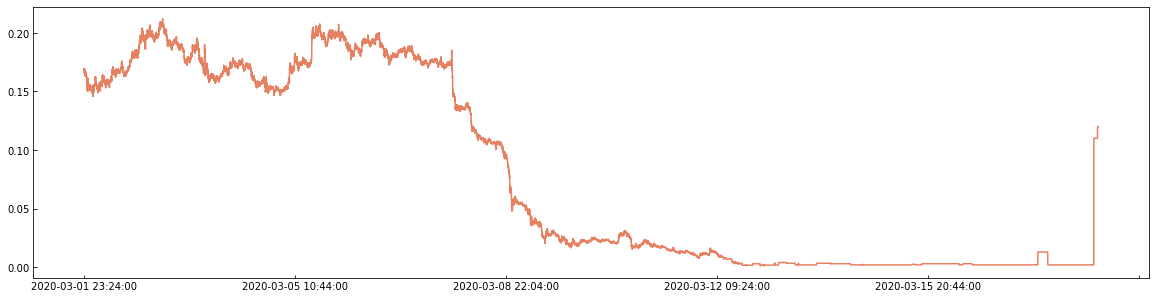

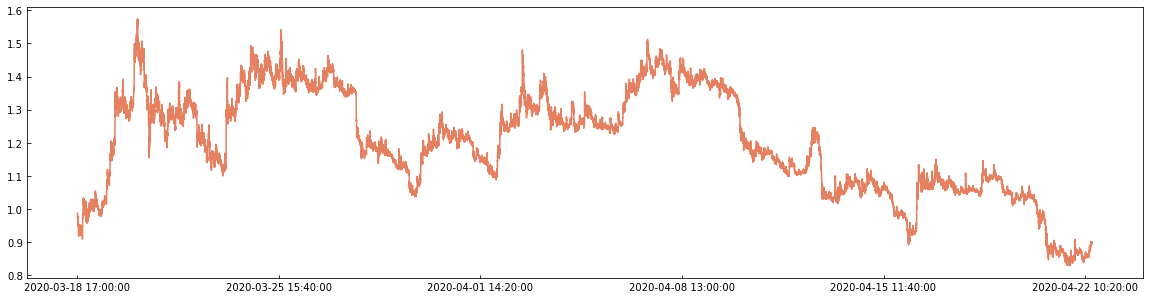

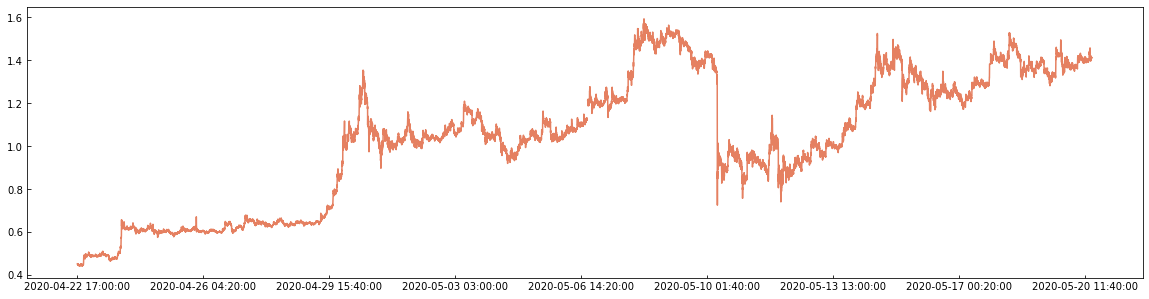

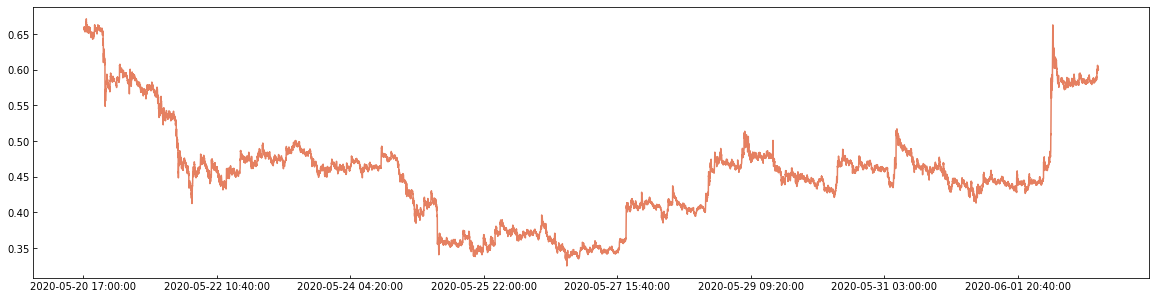

In [15]:
plot_opt(c0, get_strike_day(c0))

In [16]:
%%time
# 查找所有期权的
for i in np.sort(snapshot.kind.drop_duplicates().values):
    opt = get_digit_opt_continue(i,snapshot)
    ans = get_strike_day(opt)
    print('\n','======== ',i,' =======',end = '\n\n')
    start,end = ' 17:00:00', ' 15:59:00'
    print(ans)


 ========  market0_472_1  =======

['2020-03-16', '2020-04-20', '2020-05-18']

 ========  market0_473_1  =======

['2020-03-16', '2020-04-20', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-18']

 ========  market0_486_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_487_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_490_1  =======

['2020-03-19', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-23', '2020-05-21']

 ========  market0_491_1  =======

['2020-03-19', '2020-04-23', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-12', '2020-05-21']

 ========  market0_514_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08', '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06', '2020-05-13', '2020-05-20', '2020-05-27']

 ========  market0_515_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '202

### 计算因子，滞后一分钟

In [17]:
get_strike_day(c0)

['2020-03-18', '2020-04-22', '2020-05-20']

In [18]:
%%time
y.datetime = y.datetime.apply(lambda x:x[:4]+ '-' + x[4:6] + '-' + x[6:8] + x[8:] + ':00')
y.set_index('datetime', inplace = True)

Wall time: 1.36 s


In [19]:
def f(x):
    if x>=0.002:
        return 1
    elif x<=-0.002:
        return -1
    else:
        return 0
f = np.vectorize(f)

In [20]:
import gc

In [ ]:
%%time
# ret = -np.log(y.close).diff(-10)
end = ' 16:00:00'
start = ' 17:00:00'


long_windows = 60
medium_windows = 35
short_windows = 10
factors_num = 42
ret_time = 10

timepoint = get_strike_day(c0)
for i in range(3):
    asdf = i
    if (i == 1) | (i == 0):
#         pass
        continue
    if i == 2:
        _y = y.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start:].fillna(method = 'ffill')
    else:
        _y = y.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        
    position = []
    ret = -np.log(_c0.close).diff(-ret_time)
    
    fac0 = np.log(_y.close).diff(long_windows)
    fac1 = np.log(_y.close).diff(short_windows)
    fac2 = np.log(_y.close).diff(long_windows).rolling(long_windows).std()
    fac3 = np.log(_y.close).diff(short_windows).rolling(short_windows).std()
    fac4 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(long_windows).mean()
    fac5 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(short_windows).mean()
    fac6 = _y.vol.rolling(long_windows).sum()
    fac7 = _y.vol.rolling(short_windows).sum()
    
    fac8 = np.log(_c0.close).diff(long_windows)
    fac9 = np.log(_c0.close).diff(short_windows)
    fac10 = np.log(_c0.close).diff().rolling(long_windows).std()
    fac11 = np.log(_c0.close).diff().rolling(short_windows).std()
    fac12 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(long_windows).mean()
    fac13 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(short_windows).mean()
    fac14 = _c0.vol.rolling(long_windows).sum()
    fac15 = _c0.vol.rolling(short_windows).sum()
    
    fac16 = np.log(_p0.close).diff(long_windows)
    fac17 = np.log(_p0.close).diff(short_windows)
    fac18 = np.log(_p0.close).diff().rolling(long_windows).std()
    fac19 = np.log(_p0.close).diff().rolling(short_windows).std()
    fac20 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(long_windows).mean()
    fac21 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(short_windows).mean()
    fac22 = _p0.vol.rolling(long_windows).sum()
    fac23 = _p0.vol.rolling(short_windows).sum()
    
    fac24 = (_c0.vol - _p0.vol) / (_c0.vol+_p0.vol+1).rolling(long_windows).mean()
    fac25 = (_c0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    fac26 = (_p0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    
    fac27 = np.log(_y.close).diff(medium_windows)
    fac28 = np.log(_y.close).diff(medium_windows).rolling(medium_windows).std()
    fac29 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(medium_windows).mean()
    fac30 = np.log(_c0.close).diff(medium_windows)
    fac31 = np.log(_p0.close).diff(medium_windows)
    fac32 = (_c0.close.diff()) / (_y.close.diff()).rolling(short_windows).mean()
    fac33 = (_p0.close.diff()) / (_y.close.diff()).rolling(short_windows).mean()
    fac34 = (_c0.close.diff().diff()) / (_y.close.diff().diff()).rolling(short_windows).mean()
    fac35 = (_p0.close.diff().diff()) / (_y.close.diff().diff()).rolling(short_windows).mean()
    fac36 = (_c0.close.diff().diff()) / (_y.close.diff().diff()).diff()
    fac37 = (_p0.close.diff().diff()) / (_y.close.diff().diff()).diff()
    fac38 = (_c0.close.diff()/_y.close.rolling(medium_windows).std().diff())
    fac39 = (_p0.close.diff()/_y.close.rolling(medium_windows).std().diff())
    fac40 = fac38.rolling(medium_windows).mean()
    fac41 = fac39.rolling(medium_windows).mean()
    
    columns = ['fac{}'.format(i) for i in range(factors_num)]
    '''
    factors = pd.concat(
        [
            fac0,fac1,fac2,fac3,fac4,fac5,fac6,fac7,fac8,fac9,
            fac10,fac11,fac12,fac13,fac14,fac15,fac16,fac17,fac18,
            fac19,fac20,fac21,fac22,fac23,fac24,fac25,fac26
        ],
        axis = 1,
    )
    '''
    factors = []
    for _i in range(factors_num):
        factors.append(locals()['fac{}'.format(str(_i))])
    factors = pd.concat(factors,axis = 1)
    factors.columns = columns
    
    Y = f(np.nan_to_num(ret))
    X = np.nan_to_num(factors.values)
    
    for _i in range(1450, _y.shape[0]-120):
        X_train, Y_train =  X[_i-1440:_i-ret_time,:], Y[_i-1440:_i-ret_time]
        X_test, Y_test = X[_i+1:_i+2,:], Y[_i+1:_i+2]
        model = XGBClassifier(n_jobs = 7)
        r = model.fit(X_train, Y_train)
        prey = r.predict(X_test)
        position.append(prey[0])
        if _i % 5000 == 1450:
            gc.collect()
        if _i % 1000 == 450:
            print(_i-1450, '/', _y.shape[0]-120-1450)
#         print(_i-1450, '/', _y.shape[0]-1440, ' ', r.score(X_train,Y_train),' ',Y_test[0], ' ', prey[0])
    
    pos = np.array(position)
    a = ret[1451:]
    net = [[1/ret_time] * ret_time]
    for i in range(0, len(pos)//ret_time):
        n = []
        for j in range(ret_time):
            _ = net[-1][j] + pos[ret_time*i+j] * a[ret_time*i+j] / ret_time
            if (i!=0) & (pos[ret_time*i+j] != pos[ret_time*i+j-ret_time]):
                _ = _ - 0.001/ret_time
            n.append(_)
        net.append(n)
    
    np.save('{}.npy'.format(asdf), pos)
    
    fig,ax = plt.subplots()
    net_worth = pd.DataFrame(np.array(net),index = ret[1451:].index[::5][:len(net)])
    ax.plot(net_worth.sum(axis = 1), color = colors[4])
    for i,j in enumerate(ax.get_xticklabels()):
        if i%720 == 0:
            j.set_visible(True)
            j.set_rotation(30)
        else:
            j.set_visible(False)
    for i,j in enumerate(ax.get_xticklines()):
        if i%144 == 0:
            j.set_visible(True)
        else:
            j.set_visible(False)
    fig.savefig('{}.png'.format(asdf))
    plt.show(fig)

0 / 12382


## 实验

In [39]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=3000,
                     hall_of_fame=1000, n_components=1000,
                     function_set=function_set,
                     metric = 'pearson',
                     parsimony_coefficient=0.0005,
                     max_samples=0.9, verbose=1,
                     random_state=0, n_jobs=7)
gp.fit(X[:1450,:], Y[:1450])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.14        0.0234823        3         0.107284        0.0994564     44.40s
   1     6.52        0.0435449        3         0.157485        0.0800741      2.81m
   2     4.77         0.066059        6         0.172524        0.0483119      3.09m
   3     4.26        0.0843967        5         0.181604        0.0935228      3.16m
   4     3.89         0.119195        5         0.197719         0.146994      2.82m
   5     3.96         0.122949        6         0.214024        0.0114563      2.67m
   6     5.58         0.128546       10         0.228647        0.0723271      2.46m
   7     6.47         0.135499       14         0.236408         0.104689      2.41m
   8     6.89         0.133883       14         0.233031         0.150175  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    hall_of_fame=1000, max_samples=0.9, n_components=1000,
                    n_jobs=7, parsimony_coefficient=0.0005,
                    population_size=3000, random_state=0, verbose=1)

In [40]:
model = XGBClassifier()
r = model.fit(gp.transform(X[:1450,:]), f(Y[:1450]))
r.score(gp.transform(X[1460:1770,:]), f(Y[1460:1770]))

0.4032258064516129

In [37]:
gp.transform(X[1460:1500,:]).shape

(40, 100)

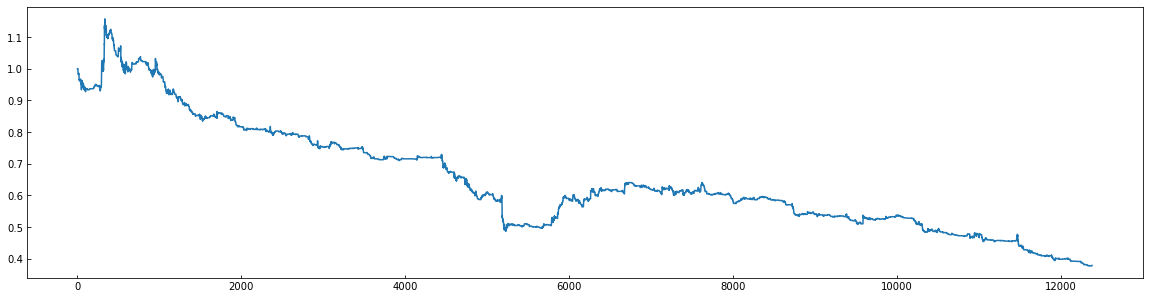

In [320]:
net = [1]
for i in range(len(pos)):
    net.append(net[-1] * (pos[i] * ret[1451+i] + 1))
    if pos[i] != 0:
        net[-1] = net[-1] * 0.999
plt.plot(net)

allmaxDrawdown:  0.36967161591212405
allMeanDrawdown: 
 0    0.336130
1    0.431283
2    0.582584
3    0.788852
4    0.556829
5    0.339832
6    0.558942
7    0.432212
8    0.582998
9    0.382815
dtype: float64


AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

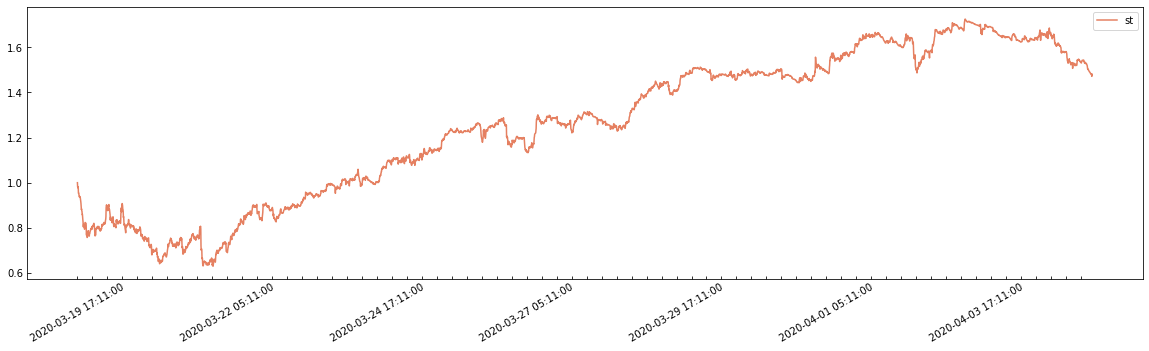

In [44]:
pos = np.load('./pos/0.npy')
#pos = np.array(position)
a = ret[1451:]
net = [[1/ret_time] * ret_time]
for i in range(0, len(pos)//ret_time):
    n = []
    for j in range(ret_time):
        _ = net[-1][j] + pos[ret_time*i+j] * a[ret_time*i+j] / ret_time
        if (i!=0) & (pos[ret_time*i+j] != pos[ret_time*i+j-ret_time]) & (pos[ret_time*i+j-ret_time] != 0):
            _ = _ - 0.002/ret_time
        n.append(_)
    net.append(n)
fig,ax = plt.subplots()
net_worth = pd.DataFrame(np.array(net),index = ret[1451:].index[::5][:len(net)])
ax.plot(net_worth.sum(axis = 1), color = colors[4], label = 'st')
# ax.plot(_c0.close/_c0.close.dropna()[0], color = colors[3], label = 'opt')
for i,j in enumerate(ax.get_xticklabels()):
    if i%720 == 0:
        j.set_visible(True)
        j.set_rotation(30)
    else:
        j.set_visible(False)
for i,j in enumerate(ax.get_xticklines()):
    if i%144 == 0:
        j.set_visible(True)
    else:
        j.set_visible(False)
ax.legend()
print('allmaxDrawdown: ', np.max(1 - net_worth.sum(axis = 1) / np.maximum.accumulate(net_worth.sum(axis = 1))))
print('allMeanDrawdown: \n', net_worth.apply(lambda x:np.max(1-x/np.maximum.accumulate(x))))
# plt.save('0-1-2%%-stopt')
plt.show(fig)

In [37]:
net_worth.iloc[-1,:]

0    0.194139
1    0.165658
2    0.166534
3    0.069812
4    0.168492
5    0.148852
6    0.142201
7    0.125144
8    0.142031
9    0.156881
Name: 2020-04-05 15:36:00, dtype: float64

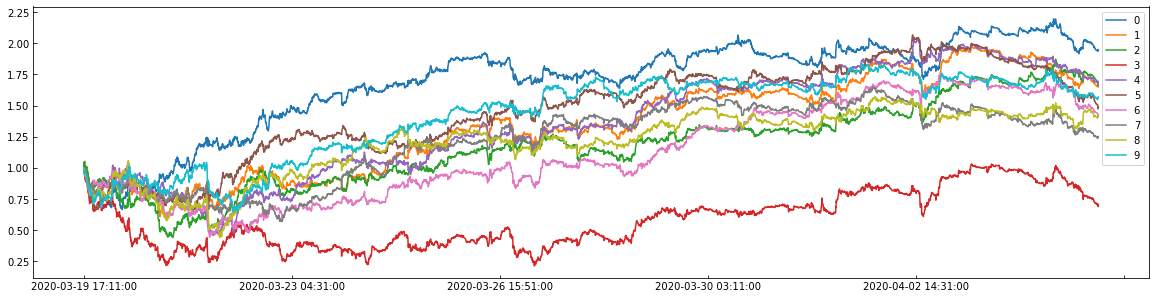

In [34]:
(net_worth * 10).plot()

In [42]:
# (_c0.close/_c0.close[0]).plot()
_c0.close.dropna()[0]

0.9873

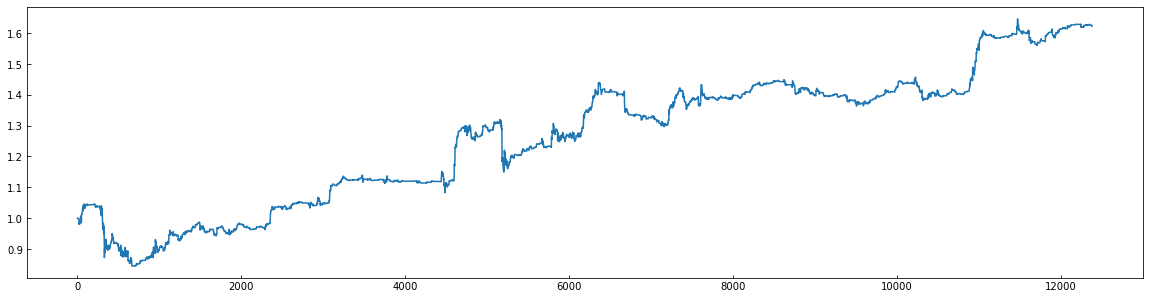

In [275]:
pos = np.array(position)
a = ret[1452:]
net = [1]
for ii in range(0, len(pos)):
    net.append(net[-1] + a[ii] * pos[ii])
    if (ii!=0) & (pos[ii] != pos[ii-1]) & (pos[ii-1] != 0):
        pass
#         net[-1] = net[-1] - 0.002

#     print(i)
fig,ax = plt.subplots()
ax.plot(np.array(net))
plt.show(fig)

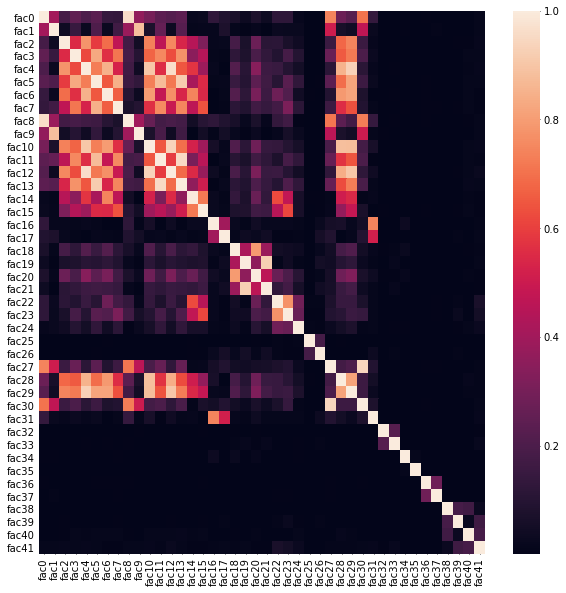

In [124]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(np.abs(factors.corr()),ax =ax)

In [142]:
np.sum(pos == f(ret[1451:1451+len(pos)].values))/len(pos)

0.39504151561220907

# Dual Thurst

1.5   1.5


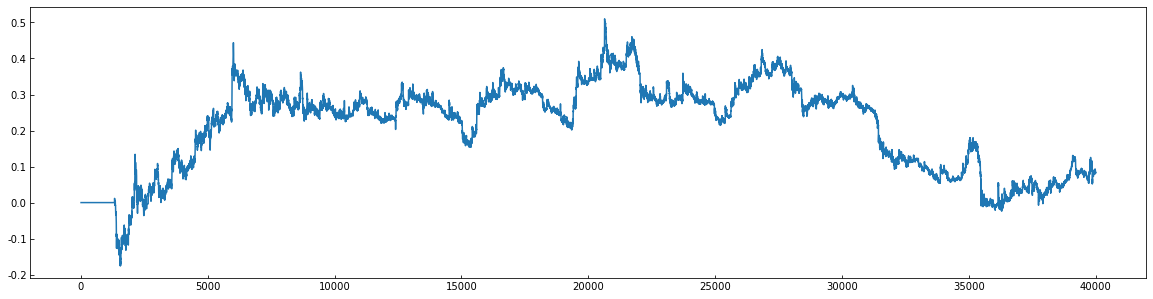

Wall time: 1min 25s


In [109]:
%%time
N = 20

Ks, Kx = 1.5, 1.5
position = [0]

for i in range(_c0.iloc[1440:,:].shape[0]):
    i = i + 1440
    _cache = _c0.iloc[i-N:i,:]
    HH = _cache.high.max()
    HC = _cache.close.max()
    LC = _cache.close.min()
    LL = _cache.low.min()

    Range = max(HH - LC, HC - LL)
    upperLine = _c0.iloc[i].open + Ks * Range
    lowerLine = _c0.iloc[i].open - Kx * Range

    if _c0.iloc[i].close > upperLine:
        position.append(1)
    elif _c0.iloc[i].close < lowerLine:
        position.append(-1)
    else:
        position.append(position[-1])

    if i > 40000 + 1440:
        break
pos = np.array(position[1:])
ret = -1 * np.log(_c0.iloc[1440:len(position) + 1440,:].close).diff(-1)
x = np.array([])
for i in range(len(pos)):
    if i == 0:
        x = np.append(x, pos[i] * ret[i])
    else:
        if pos[i] == pos[i-1]:
            x = np.append(x, pos[i] * ret[i])
        else:
            x = np.append(x, pos[i] * ret[i] - 0.001)
plt.plot(x.cumsum())
print(Ks, ' ', Kx)
plt.show()

1   1


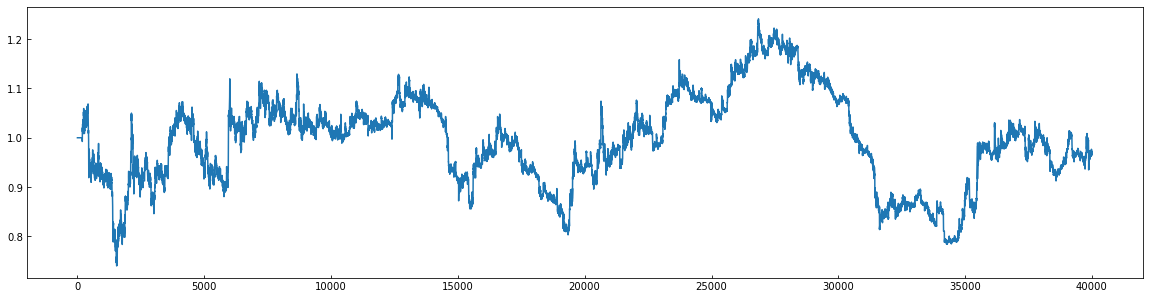

1   1


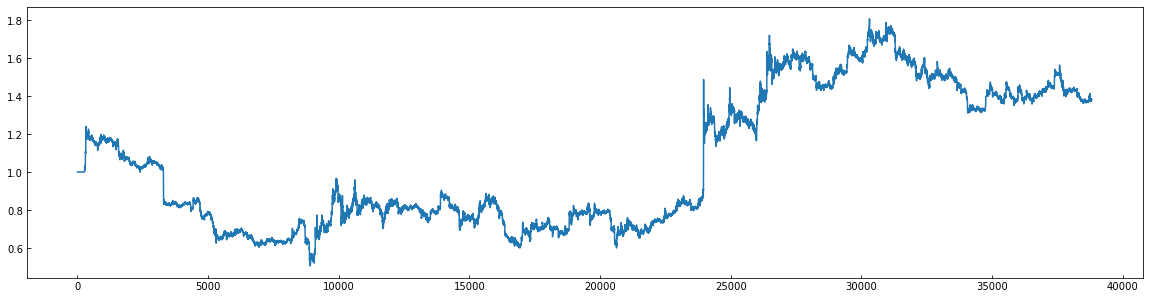

1   1


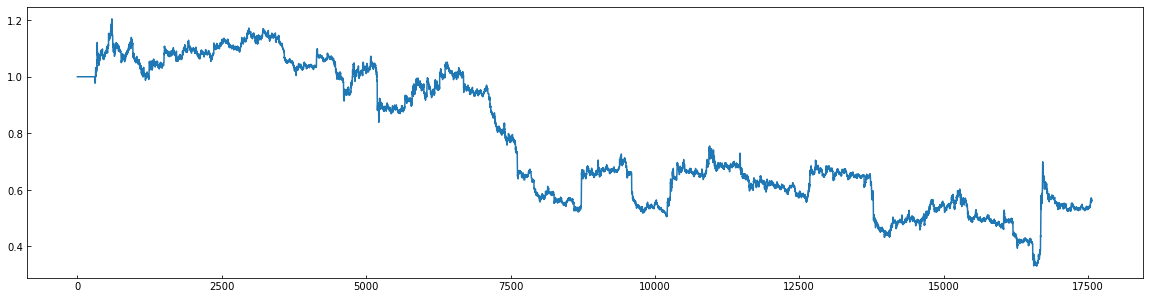

In [114]:
timepoint = get_strike_day(c0)
for i in range(3):
    asdf = i
    if (i == 2) | (i == 1):
        pass
#         continue
    if i == 2:
        _y = y.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start:].fillna(method = 'ffill')
    else:
        _y = y.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')

    N = 20

    Ks, Kx = 1, 1
    position = [0]

    for i in range(_c0.iloc[1440:,:].shape[0]):
        i = i + 1440
        _cache = _c0.iloc[i-N:i,:]
        HH = _cache.high.max()
        HC = _cache.close.max()
        LC = _cache.close.min()
        LL = _cache.low.min()

        Range = max(HH - LC, HC - LL)
        upperLine = _c0.iloc[i].open + Ks * Range
        lowerLine = _c0.iloc[i].open - Kx * Range

        if _c0.iloc[i].close > upperLine:
            position.append(1)
        elif _c0.iloc[i].close < lowerLine:
            position.append(-1)
        else:
            position.append(position[-1])

        if i > 40000 + 1440:
            break
    pos = np.array(position[1:])
    ret = -1 * np.log(_c0.iloc[1440:len(position) + 1440,:].close).diff(-1)
    x = np.array([])
    for i in range(len(pos)):
        if i == 0:
            x = np.append(x, pos[i] * ret[i])
        else:
            if pos[i] == pos[i-1]:
                x = np.append(x, pos[i] * ret[i])
            else:
                x = np.append(x, pos[i] * ret[i] - 0.001)
    plt.plot(1+x.cumsum())
    print(Ks, ' ', Kx)
    plt.show()